In [1]:
from matplotlib import pyplot as plt
import mne
import numpy as np

# Install mne  
https://mne.tools/stable/install/manual_install.html#manual-install 

Reading /Users/polya/workshop/python2/project/data/PHY_ID0000-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...   29990.00 ms
        0 CTF compensation matrices available
Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
(841, 7, 3000)
(7, 3000)
(3000,)
[0 0 0 0 0 0 0 0 0 0]
841
Stage for epoch 25: 0


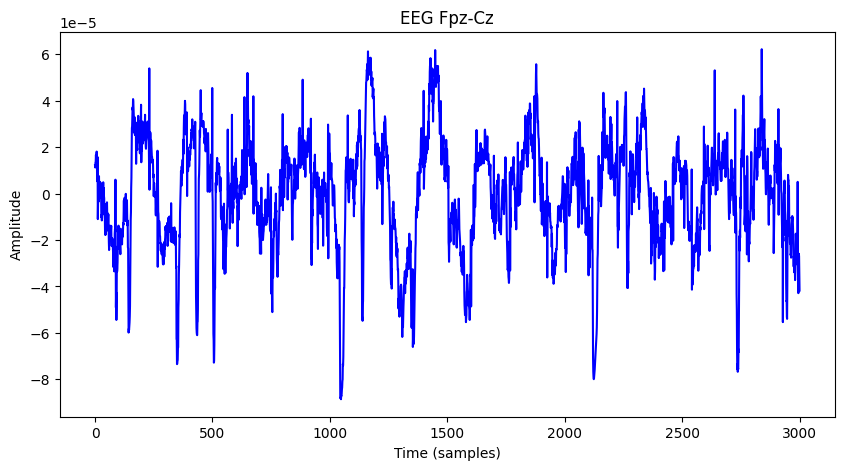

In [2]:
# PSG
epo = mne.read_epochs('data/PHY_ID0000-epo.fif', preload=True)
data = epo.get_data(copy=True)

print(data.shape) # (n_epochs, n_channels, n_times)
print(data[0].shape) # (n_channels, n_times)
print(data[0][0].shape) # (n_times,)

print(epo.events[:10, 2]) # first 10 sleep stage labels
print(len(epo.events[:, 2])) # number of events
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(data[25][0], label='EEG Fpz-Cz', color='blue')
ax.set_title('EEG Fpz-Cz')
ax.set_xlabel('Time (samples)')
ax.set_ylabel('Amplitude')

# get the sleep stage 
labels = epo.events[:, 2]
print(f'Stage for epoch 25: {labels[25]}')


In [3]:
# get the channel names 
epo.ch_names

['EEG Fpz-Cz',
 'EEG Pz-Oz',
 'EOG horizontal',
 'Resp oro-nasal',
 'EMG submental',
 'Temp rectal',
 'Event marker']

all code above was provided in the data.